<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Demo_SBI_HMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Replace version 3.2 by 3.5
!pip uninstall -y matplotlib
!pip install -q matplotlib==3.5.0
# Needs Re-initialize the environment then pass to the next cell

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
     |████████████████████████████████| 11.2 MB 9.0 MB/s 
     |████████████████████████████████| 42 kB 335 kB/s 
     |████████████████████████████████| 965 kB 23.4 MB/s 


In [1]:
!pip install --upgrade --quiet sbi

     |████████████████████████████████| 297 kB 4.6 MB/s 
     |████████████████████████████████| 722 kB 56.3 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 


In [2]:
!pip install --upgrade --quiet numpyro

     |████████████████████████████████| 292 kB 5.4 MB/s 


In [3]:
import numpy as np
import jax
import jax.numpy as jnp
import numpyro

import torch
import pyro

import torch.distributions as torch_dist

import sbi
from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils

In [7]:
print(sbi.__version__, pyro.__version__, jax.__version__)

0.20.0 1.8.2 0.3.23


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az
import matplotlib.patches as mpatches

In [9]:
assert mpl.__version__ == '3.5.0'

In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("running on device:", device)

running on device: cpu


In [11]:
############
def overplot_lines(axes, xs, reverse=False, **kwargs):
    """
    Overplot lines on a figure generated by ``corner.corner``
    Parameters
    ----------
    fig : Figure
        The figure generated by a call to :func:`corner.corner`.
    xs : array_like[ndim]
       The values where the lines should be plotted. This must have ``ndim``
       entries, where ``ndim`` is compatible with the :func:`corner.corner`
       call that originally generated the figure. The entries can optionally
       be ``None`` to omit the line in that axis.
    reverse: bool
       A boolean flag that should be set to 'True' if the corner plot itself
       was plotted with 'reverse=True'.
    **kwargs
        Any remaining keyword arguments are passed to the ``ax.axvline``
        method.
    """
    K = len(xs)
    if reverse:
        for k1 in range(K):
            if xs[k1] is not None:
                axes[K - k1 - 1, K - k1 - 1].axvline(xs[k1], **kwargs)
            for k2 in range(k1 + 1, K):
                if xs[k1] is not None:
                    axes[K - k2 - 1, K - k1 - 1].axvline(xs[k1], **kwargs)
                if xs[k2] is not None:
                    axes[K - k2 - 1, K - k1 - 1].axhline(xs[k2], **kwargs)

    else:
        for k1 in range(K):
            if xs[k1] is not None:
                axes[k1, k1].axvline(xs[k1], **kwargs)
            for k2 in range(k1 + 1, K):
                if xs[k1] is not None:
                    axes[k2, k1].axvline(xs[k1], **kwargs)
                if xs[k2] is not None:
                    axes[k2, k1].axhline(xs[k2], **kwargs)

def plot_params_kde(samples,hdi_probs=[0.393, 0.865, 0.989], 
                    patName=None, fname=None, pcut=None, reference_values=None, 
                    reference_color='k', label_size=10,labeller=None, limits=None,
                   var_names=None, point_estimate="median", figsize=(8,8)):
    """
     limts = [[min_1,max_1], ... , [min_N, max_N]] N varaibles
    """
        
    if pcut is not None:
        low = pcut[0]
        up  = pcut[1] 
        #keep only data in the [low, up] percentiles ex. 0.5, 99.5
        samples={name:value[(value>np.percentile(value,low)) &  (value<np.percentile(value,up))] \
          for name, value in samples.items()}
        len_min = np.min([len(value) for name, value in samples.items()])
        len_max = np.max([len(value) for name, value in samples.items()])
        if (len_max-len_min)>0.01*len_max:
            print(f"Warning: pcut leads to min/max spls size = {len_min}/{len_max}")
        samples = {name:value[:len_min] for name, value in samples.items()}
    
    axs= az.plot_pair(
            samples,
            var_names=var_names,
            kind="kde",
            labeller=labeller,
            figsize=figsize,
            marginal_kwargs={"plot_kwargs": {"linewidth": 2, "c": "b"}},
            kde_kwargs={
#                "hdi_probs": [0.68, 0.9],  # Plot 68% and 90% HDI contours
                "hdi_probs":hdi_probs,  # 1, 2 and 3 sigma contours
                "contour_kwargs":{"colors":('r', 'green', 'blue'), "linewidths":2},
                "contourf_kwargs":{"alpha":0},
            },
            point_estimate_kwargs={"lw": 2, "c": "b"},
            marginals=True, textsize=label_size, point_estimate=point_estimate,
            reference_values=reference_values, reference_values_kwargs={"c":reference_color}
        );
    
    if reference_values is not None:
      overplot_lines(axs,list(reference_values.values()), color=reference_color)
      if limits is not None:
        assert len(limits) == len(samples.keys()), "wrong number of limits"
        for i in range(0,axs.shape[0]):
          for j in range(0,i+1):
            if j == i:
              axs[i,i].set_xlim(limits[i])
            else:
              axs[i,j].set_xlim(limits[j])
              axs[i,j].set_ylim(limits[i])

    plt.tight_layout()
    
    if patName is not None:
#        patName_patch = mpatches.Patch(color='b', label=patName)
#        axs[0,0].legend(handles=[patName_patch], fontsize=40, bbox_to_anchor=(1, 0.7));
      fig = axs[0,0].get_figure()
      fig.suptitle(patName)
    if fname is not None:
        plt.savefig(fname)
        plt.close()
    else:
        plt.show();


In [12]:
#torch, numpy, random seeds set manualy
pyro.set_rng_seed(42)

# Data

In [13]:
N = 40
t = np.sort(np.random.rand(N))

In [14]:
@jax.jit
def make_data(theta, t):
    a, mu, sig, b0, b1 = theta

    signal = a * jnp.exp(-(mu-t)**2 / (2*sig**2))
    bkgd  = b0 + b1*t

    return signal + bkgd

In [15]:
theta_true = jnp.array([2, 0.5, 0.1, 1.2, 0.4])
labels = ["a","mu","sig","b0","b1"]
truth = {k:v for k,v in zip(labels, theta_true)}

In [16]:
x_o_noiseless = make_data(theta_true, t)

In [17]:
key = jax.random.PRNGKey(42)
key, subkey  = jax.random.split(key,2)
sig_noise =  0.2/jnp.sqrt(x_o_noiseless) # non constant sigma of noise

In [18]:
key, subkey  = jax.random.split(key,2)
x_o = x_o_noiseless + jax.random.multivariate_normal(subkey, mean=jnp.array([0.]*N), cov=jnp.diag(sig_noise**2))

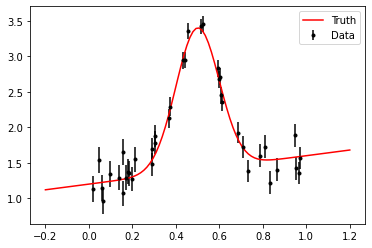

In [19]:
t_full = np.linspace(-0.2,1.2,100)
x_full_no_noise = make_data(theta_true,t_full) 
plt.errorbar(t,x_o,yerr=sig_noise, fmt=".k", capsize=0, label="Data");
plt.plot(t_full, x_full_no_noise,c='r',label="Truth")
plt.legend();

# HMC

In [18]:
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [19]:
truth

{'a': DeviceArray(2., dtype=float32),
 'mu': DeviceArray(0.5, dtype=float32),
 'sig': DeviceArray(0.1, dtype=float32),
 'b0': DeviceArray(1.2, dtype=float32),
 'b1': DeviceArray(0.4, dtype=float32)}

In [20]:
def model(t, x_o=None, sig_noise=0.1):

    # define parameters with priors
    a = numpyro.sample('a', dist.Uniform(0, 10))
    mu = numpyro.sample('mu', dist.Uniform(0, 1))
    sig = numpyro.sample('sig', dist.Uniform(0, 2))
    b0 = numpyro.sample('b0', dist.Uniform(0, 2))
    b1 = numpyro.sample('b1', dist.Uniform(0, 2))

    # implement the model
    theta = jnp.array([a,mu,sig,b0,b1])
    x = make_data(theta,t)

    # condition the model to the observation x_o
    numpyro.sample('obs', dist.Normal(x, sig_noise), obs=x_o)


In [21]:
key, subkey  = jax.random.split(key,2)

In [22]:
# run HMC with NUTS
kernel = NUTS(model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(subkey, t=t, x_o = x_o, sig_noise=sig_noise)
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:52<00:00, 75.98it/s, 15 steps of size 2.24e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.03      0.07      2.03      1.92      2.14   2225.74      1.00
        b0      1.27      0.06      1.28      1.18      1.37   1123.41      1.00
        b1      0.26      0.09      0.26      0.11      0.41   1127.39      1.00
        mu      0.50      0.00      0.50      0.49      0.51   2084.94      1.00
       sig      0.10      0.00      0.10      0.09      0.11   1899.31      1.00

Number of divergences: 0


In [23]:
hmc_spls = mcmc.get_samples()

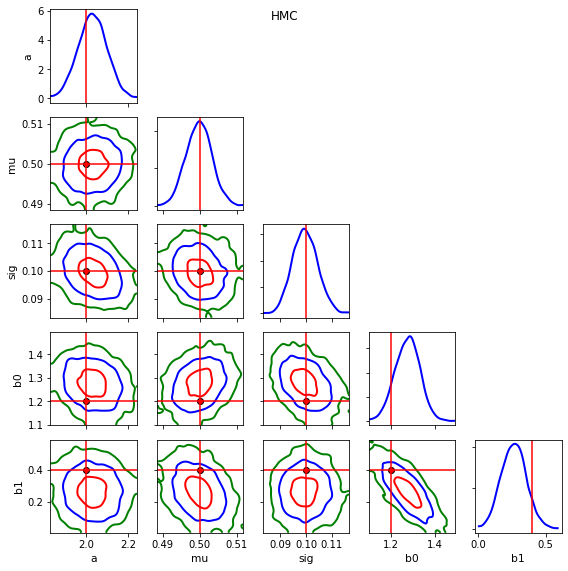

In [24]:
plot_params_kde(hmc_spls,var_names=labels, figsize=(8,8), limits=None,
            point_estimate=None, reference_values=truth, reference_color='r',
            patName="HMC", fname=None);


In [25]:
from numpyro.infer import Predictive

In [26]:
predictive = Predictive(model, posterior_samples=hmc_spls)
# need to set noise to zero
# since the full model contains noise contribution
predictions = predictive(subkey, t=t_full, sig_noise=0.0)['obs']


In [27]:
#predictions.shape   (3000, 100)

In [28]:
# select 50 predictions to show
inds = jax.random.randint(subkey, (50,) , 0, mcmc.num_samples)
predictions = predictions[inds]


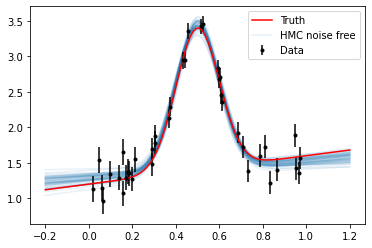

In [29]:
t_full = np.linspace(-0.2,1.2,100)
x_full_no_noise = make_data(theta_true,t_full) 
plt.errorbar(t,x_o,yerr=sig_noise, fmt=".k", capsize=0, label="Data");
plt.plot(t_full, x_full_no_noise,c='r',label="Truth")
for i in range(predictions.shape[0]):
  if i==0:
    tag="HMC noise free"
  else:
    tag=None
  plt.plot(t_full, predictions[i],c="C0",alpha=0.1, zorder=-1,label=tag);
plt.legend();

#SBI

In [21]:
import pyro.distributions as pyro_dist

In [22]:
# theta param priors
prior_a = pyro_dist.Uniform(0.0*torch.ones(1,device=device),10.0*torch.ones(1, device=device)) 
prior_mu = pyro_dist.Uniform(0.0*torch.ones(1,device=device),1.0*torch.ones(1, device=device)) 
prior_sig =  pyro_dist.Uniform(1e-5*torch.ones(1,device=device),2.0*torch.ones(1, device=device)) 
prior_b0 = pyro_dist.Uniform(0.0*torch.ones(1,device=device),2.0*torch.ones(1, device=device)) 
prior_b1 = pyro_dist.Uniform(0.0*torch.ones(1,device=device),2.0*torch.ones(1, device=device)) 

In [23]:
# Take care of the order
prior = [prior_a, prior_mu, prior_sig, prior_b0, prior_b1]

In [24]:
sig_noise_torch = torch.tensor(np.asarray(sig_noise), device=device)

In [25]:
# the simulator 
def simulator(theta, t, sig_noise):

  theta = theta.cpu().numpy()  # torch to numpy

  x_noiseless = make_data(theta, t) # here takes the JAX version
  x_noiseless = torch.tensor(np.asarray(x_noiseless), device=device)  #JAX -> torch

  # add noise consistent with true observation
  x = x_noiseless + sig_noise * torch.randn(t.shape[0], device=device)
  
  return x.to(device=device)


In [26]:
#simulator(torch.tensor(np.asarray(theta_true), device=device), t, sig_noise_torch)

In [30]:
# conditions the simulator with the location of the data (t) and the noise sigma
cond_simulator = lambda theta: simulator(theta,t,sig_noise_torch)


In [31]:
#adapt/check the prior & simulator for SBI
cond_simulator, prior = prepare_for_sbi(cond_simulator, prior)


/usr/local/lib/python3.7/dist-packages/sbi/utils/user_input_checks.py:72: UserWarning: Prior was provided as a sequence of 5 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  components of the parameter."""


In [32]:
x_o_tensor = torch.tensor(np.asarray(x_o), device=device)[None]

In [39]:
def do_multi_pass(num_simu = 10_000, num_rounds = 1, max_num_epochs=1_000, do_plots=False):

    # multi rounds: first round simulates from the prior, second round simulates parameter set
    # that were sampled from the obtained posterior.
    # The specific observation we want to focus the inference on is x_o (single)

    # default:  hidden_features: int = 50, num_transforms: int = 5,  num_blocks: int = 2,
    density_estimator_build_fun = posterior_nn(model="maf",  hidden_features=64)
    inference = SNPE(prior=prior, device=device,
                     density_estimator=density_estimator_build_fun)

    posteriors = []
    proposal = prior

    for i in range(num_rounds):
        if i==0:
            theta, x = simulate_for_sbi(cond_simulator, proposal, num_simulations=num_simu)
        else:
            theta = proposal.sample((num_simu,))
            x = cond_simulator(theta)

        density_estimator = inference.append_simulations(
            theta, x, proposal=proposal
            ).train(max_num_epochs=max_num_epochs)
          
        posterior = inference.build_posterior(density_estimator)
        posteriors.append(posterior)

        if do_plots:
          sbi_samples = posterior.sample((10000,), x=x_o_tensor)
          sbi_samples = sbi_samples.cpu().numpy()
          values = [sbi_samples[:,i]for i in range(sbi_samples.shape[1])]
          sbi_spls = dict(zip(labels,values))
          plot_params_kde(sbi_spls,var_names=labels, figsize=(8,8), limits=None,
              point_estimate=None, reference_values=truth, reference_color='r',
              patName=f"SNPE({i})", fname=None);


        proposal = posterior.set_default_x(x_o_tensor) 


    return  posteriors

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 179 epochs.

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

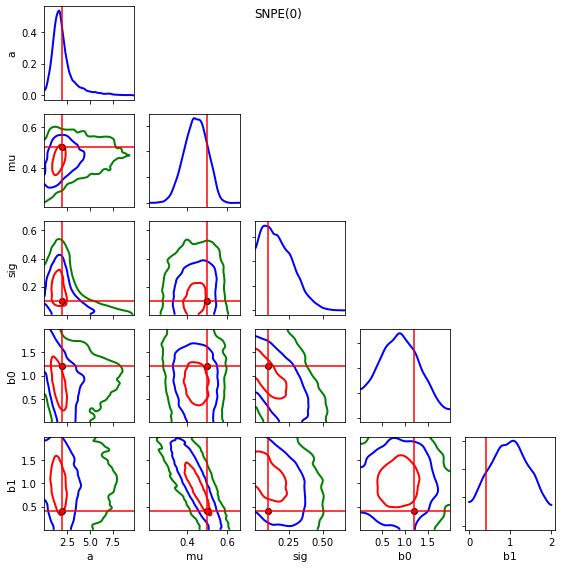

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 73 epochs.

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

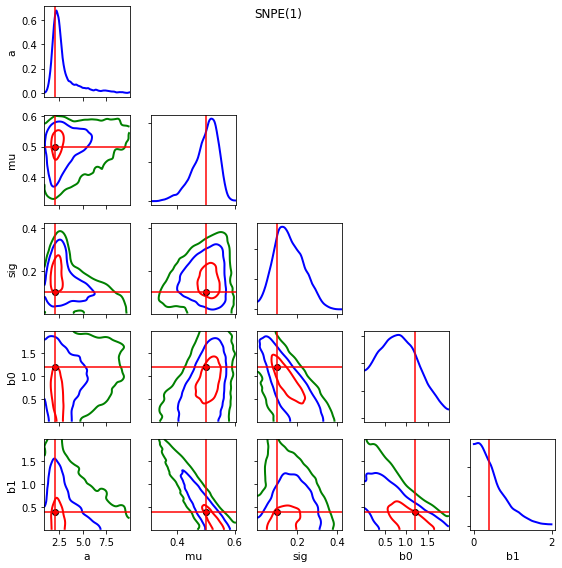

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

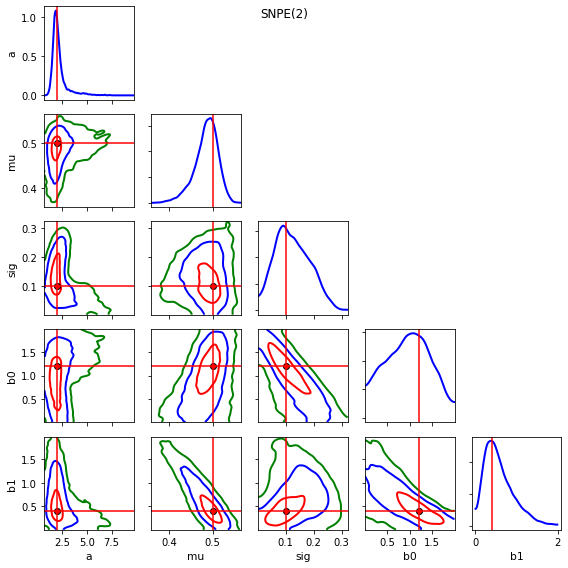

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

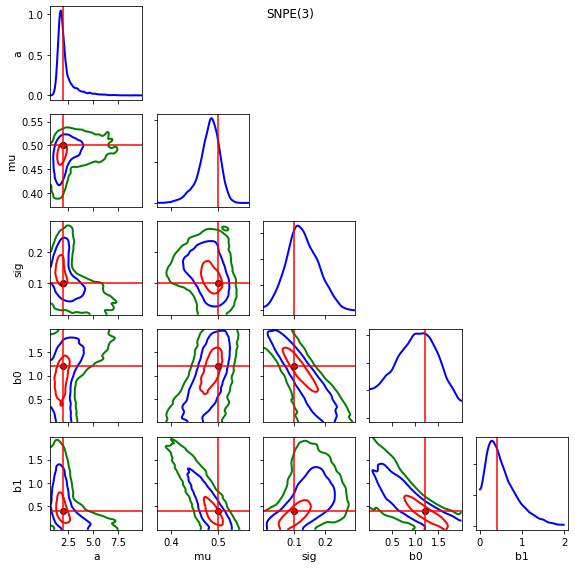

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

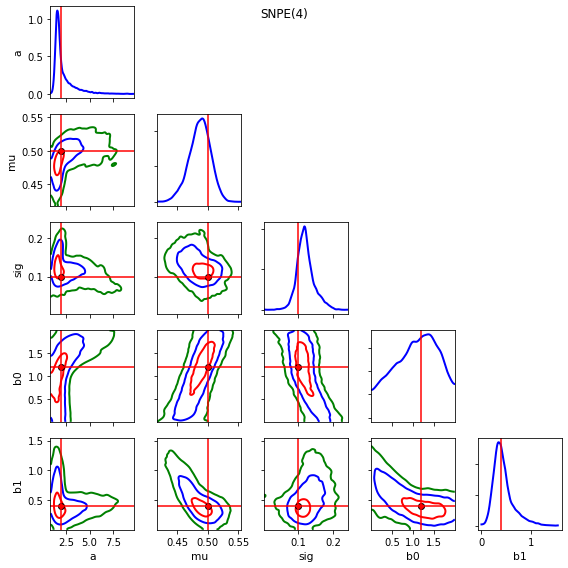

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 76 epochs.

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

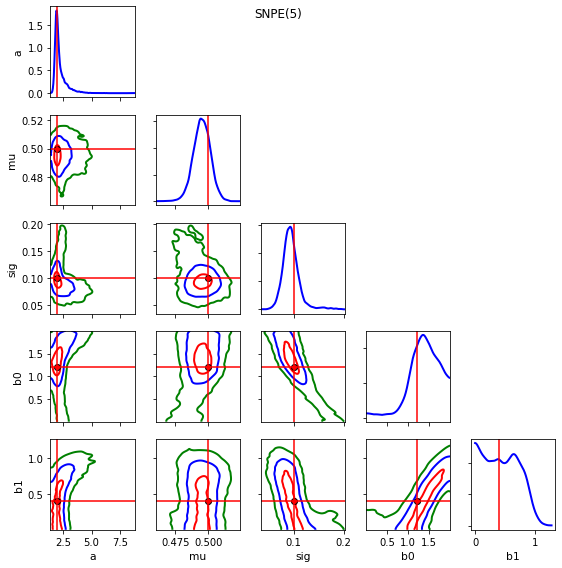

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

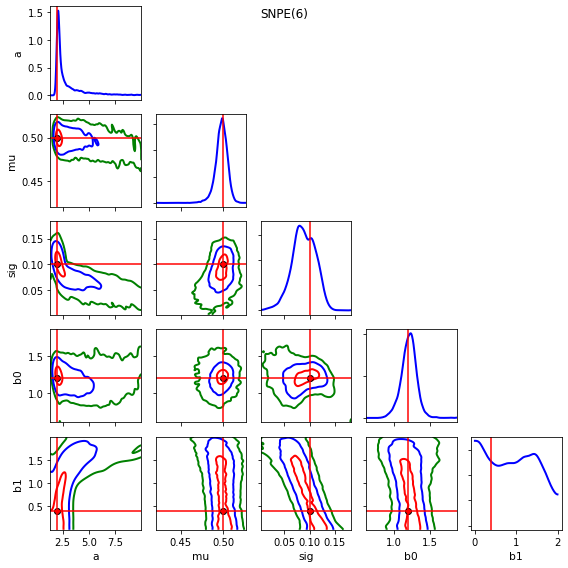

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

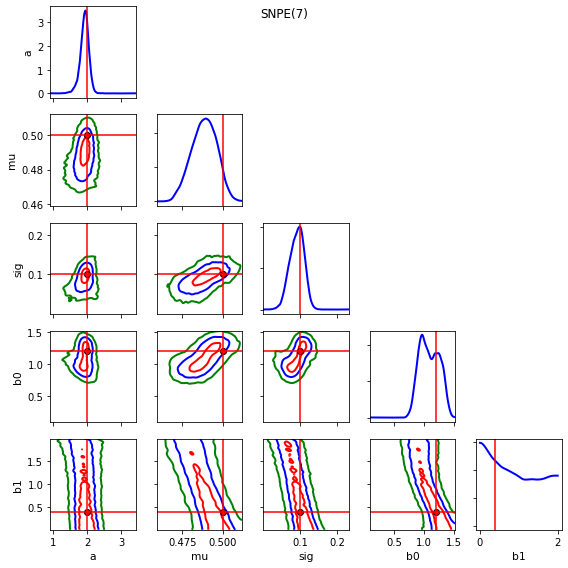

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

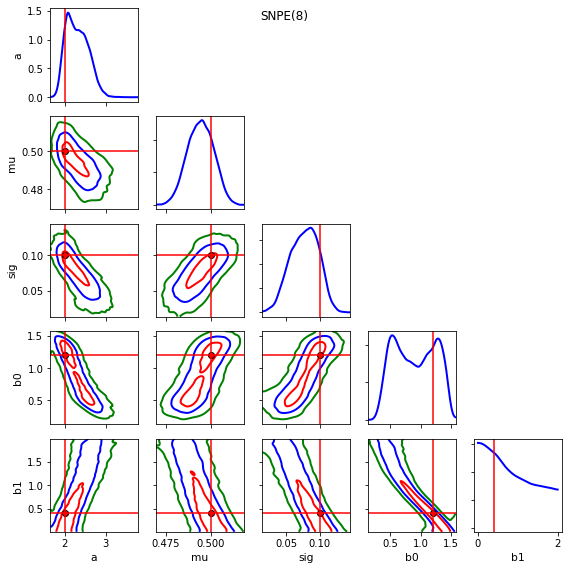

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

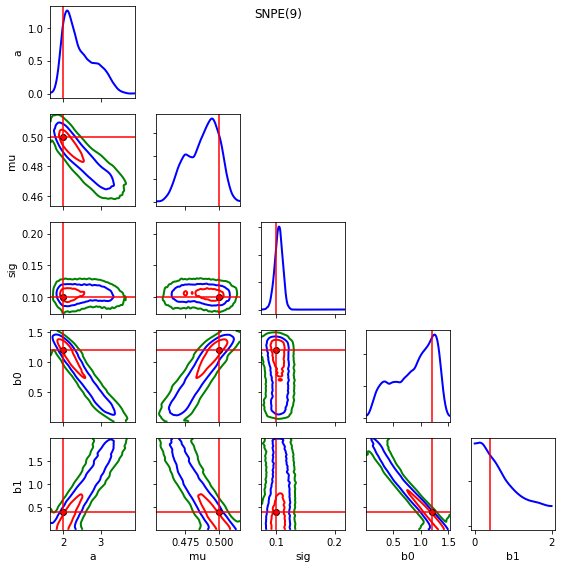

In [40]:
posteriors = do_multi_pass(num_simu = 1_000, num_rounds = 10, do_plots=True)

In [41]:
sbi_samples = posteriors[-1].sample((10000,), x=x_o_tensor)
sbi_samples = sbi_samples.cpu().numpy()


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [36]:
def plot_samples(sbi_samples):
  inds = np.random.randint(sbi_samples.shape[0], size=50)
  t_full = np.linspace(-0.2,1.2,100)
  x_full_no_noise = make_data(theta_true,t_full) 
  plt.errorbar(t,x_o,yerr=sig_noise, fmt=".k", capsize=0, label="Data");
  plt.plot(t_full, x_full_no_noise,c='r',label="Truth")
  for i,ind in enumerate(inds):
    theta_ =  sbi_samples[ind]
    if i==0:
      tag="SNPE"
    else:
      tag=None
    plt.plot(t_full, make_data(theta_,t_full),c="C0",alpha=0.2, zorder=-1,label=tag);
  plt.legend();

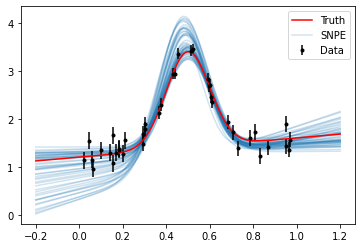

In [43]:
plot_samples(sbi_samples)

In [169]:
posteriors = do_multi_pass(num_simu = 50_000, num_rounds = 2)

/usr/local/lib/python3.7/dist-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


Running 50000 simulations.:   0%|          | 0/50000 [00:00<?, ?it/s]

 Neural network successfully converged after 137 epochs.

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 80 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

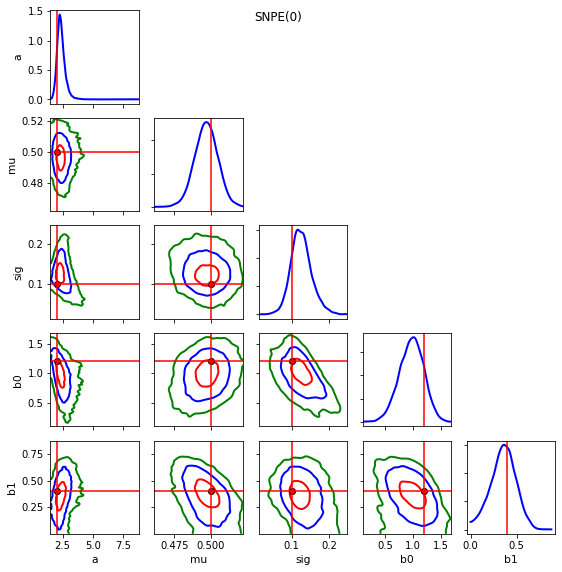

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

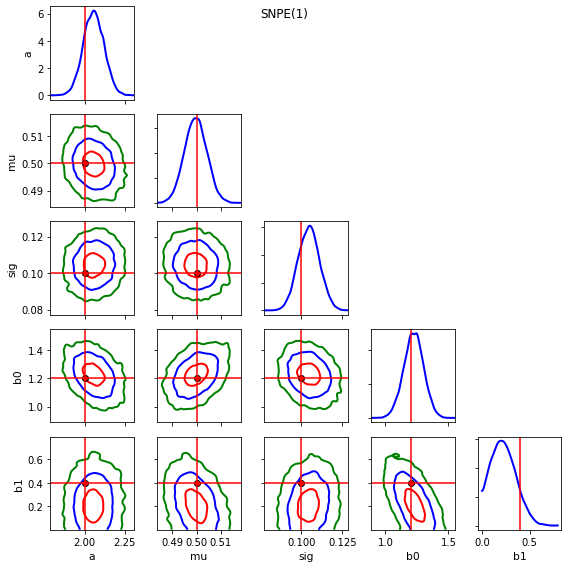

In [170]:
for ip, post in enumerate(posteriors):
  sbi_samples = post.sample((10000,), x=x_o_tensor)
  sbi_samples = sbi_samples.cpu().numpy()
  values = [sbi_samples[:,i] for i in range(sbi_samples.shape[1])]
  sbi_spls = dict(zip(labels,values))
  plot_params_kde(sbi_spls,var_names=labels, figsize=(8,8), limits=None,
            point_estimate=None, reference_values=truth, reference_color='r',
            patName=f"SNPE({ip})", fname=None);


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

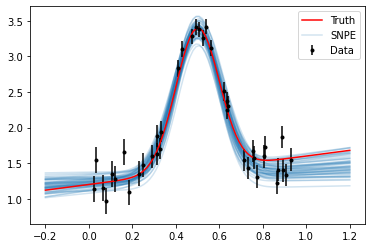

In [173]:
sbi_samples = posteriors[-1].sample((10000,), x=x_o_tensor)
sbi_samples = sbi_samples.cpu().numpy()
plot_samples(sbi_samples)

In [45]:
sbi.__version__

'0.20.0'

In [47]:
from joblib import Parallel, delayed
from sbi.utils.posterior_ensemble import NeuralPosteriorEnsemble

ensemble_size = 2
theta, x = simulate_for_sbi(cond_simulator, prior, num_simulations=50_000)

def train_nn():
    density_estimator_build_fun = posterior_nn(model="maf",  hidden_features=64)
    inference = SNPE(prior=prior, device=device,
                     density_estimator=density_estimator_build_fun)
    _ = inference.append_simulations(theta, x).train()
    return inference.build_posterior()

posteriors = Parallel(n_jobs=-1)(delayed(train_nn)() for i in range(ensemble_size))
final_posterior = NeuralPosteriorEnsemble(posteriors)

Running 50000 simulations.:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 5040 posterior samples:   0%|          | 0/5040 [00:00<?, ?it/s]

Drawing 4960 posterior samples:   0%|          | 0/4960 [00:00<?, ?it/s]

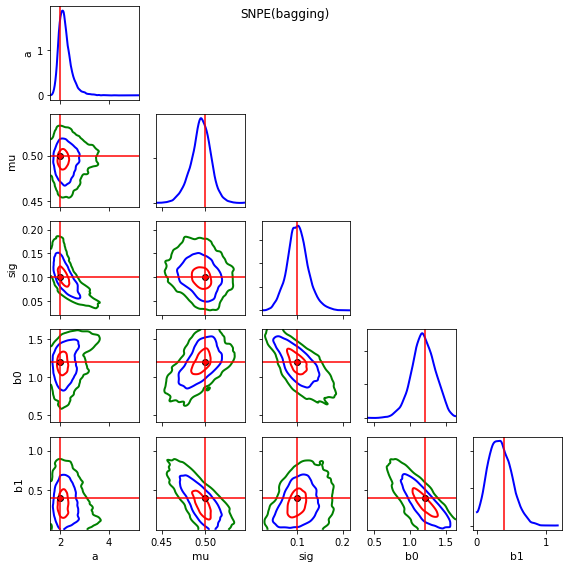

In [48]:
sbi_samples = final_posterior.sample((10000,), x=x_o_tensor)
sbi_samples = sbi_samples.cpu().numpy()
values = [sbi_samples[:,i] for i in range(sbi_samples.shape[1])]
sbi_spls = dict(zip(labels,values))
plot_params_kde(sbi_spls,var_names=labels, figsize=(8,8), limits=None,
            point_estimate=None, reference_values=truth, reference_color='r',
            patName=f"SNPE(bagging)", fname=None);


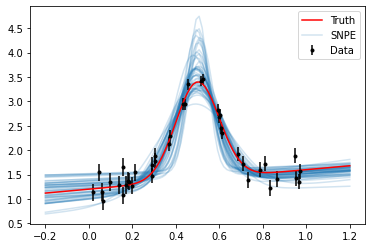

In [49]:
plot_samples(sbi_samples)